# Проверка для одного слова

В этом ноутбуке производилась проверка для одного слова с использованием уже готовых данных. Было произведено построение графиков, анализ метрик

## Подготовка данных: открытие заготовленных файлов (spacy документы, переведенный и оригинальный текст, выравнивания)

In [ ]:
import spacy
from spacy.tokens import DocBin
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
ru_stopwords = set(stopwords.words("russian"))
en_stopwords = set(stopwords.words("english"))

from string import punctuation
punct_list = [c for c in punctuation]
punct_list.append('--')
punct_list.append('...')
punct_list.append('–')

In [ ]:
with open("corpora/subtitles/translations/opus10_spacy.bin", "rb") as file:
    en_translated_bytes_data = file.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(en_translated_bytes_data)
en_translated_docs = list(doc_bin.get_docs(nlp.vocab))

with open("corpora/subtitles/en_subtitles_spacy_dump.bin", "rb") as file:
    en_bytes_data = file.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(en_bytes_data)
en_docs = list(doc_bin.get_docs(nlp.vocab))

with open("corpora/subtitles/ru_subtitles_spacy_dump.bin", "rb") as file:
    ru_bytes_data = file.read()

nlp = spacy.blank("ru")
doc_bin = DocBin().from_bytes(ru_bytes_data)
ru_docs = list(doc_bin.get_docs(nlp.vocab))
ru_docs[5]

In [ ]:
with open("corpora/subtitles/numerical_alignment/subtitles_inter.txt", "rt", encoding="utf-8") as file:
    aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/numerical_alignment/subtitles_itermax.txt", "rt", encoding="utf-8") as file:
    aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/numerical_alignment/subtitles_mwmf.txt", "rt", encoding="utf-8") as file:
    aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/translations/inter", "rt", encoding="utf-8") as file:
    t_aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/translations/itermax", "rt", encoding="utf-8") as file:
    t_aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/translations/mwmf", "rt", encoding="utf-8") as file:
    t_aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

## Функции для анализа и построения графиков

In [175]:
def plot_variety_pie(variety_dict, original_word: str):
    variety_dict_items = list(variety_dict.items())
    variety_dict_items.sort(key=lambda x: -len(x[1]))

    translations = []
    # translations.append("other")
    number_of_matches = []
    pre_number_of_matches = [len(x[1]) for x in variety_dict_items]
    total_words = sum(pre_number_of_matches)
    other_matches = 0
    for key, val in variety_dict_items:
        # if len(val) < (total_words / 100):
        #     other_matches += len(val)
        # else:
            if key == "other":
                continue
            translations.append(key)
            number_of_matches.append(len(val))
    
    translations.append("other")
    number_of_matches.append(len(variety_dict["other"]))
    
    # number_of_matches.append(other_len)

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%".format(pct) # return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(number_of_matches, autopct = lambda pct: func(pct, number_of_matches), labels = translations)

    plt.title(original_word)
    plt.legend(bbox_to_anchor=(1.03, 0.8), loc="upper left")

    # show plot
    plt.show()

In [ ]:
def get_variety_dict_from_alignment(original_word: str, aligned_text: list, t_aligned_text: list):
    variety_dict = defaultdict(lambda : set())
    translation_dict = defaultdict(lambda : set())
    for i, num_sentence_pairs in tqdm(enumerate(aligned_text)):
        if len(num_sentence_pairs) == 0 or len(en_translated_docs[i]) == 0:
            continue
        
        phrase = []
        for src_idx, tgt_idx in num_sentence_pairs:
            try:
                if ru_docs[i][src_idx].lemma_.lower() == original_word \
                    and en_docs[i][tgt_idx].text.lower() not in en_stopwords \
                        and en_docs[i][tgt_idx].text.lower() not in punct_list:
                    phrase.append(en_docs[i][tgt_idx].lemma_.lower())

            except:
                print("Error in original text:", i, src_idx, tgt_idx)
                continue

        if phrase:

            translated_phrase = []
            for tsrc_idx, ttgt_idx in t_aligned_text[i]:
                try:
                    tlemma = en_translated_docs[i][ttgt_idx].lemma_.lower()
                    if ru_docs[i][tsrc_idx].lemma_.lower() == original_word \
                        and tlemma not in en_stopwords \
                            and tlemma not in punct_list:
                        # translation_dict[tlemma].append(i)
                        translated_phrase.append(tlemma)
                except:
                    print("Error in translated text:", i, tsrc_idx, ttgt_idx)
                    continue
            
            if translated_phrase:
                phrase.sort()
                phrase = ' '.join(phrase)
                variety_dict[phrase].add(i)
                translated_phrase.sort()
                translated_phrase = ' '.join(translated_phrase)
                translation_dict[translated_phrase].add(i)

    return variety_dict, translation_dict

In [ ]:
def distil_dicts(orig, trans):
    sum_all = sum(map(lambda x: len(x), orig.values()))
    blacklist = []
    new_orig = defaultdict(set)
    for key, value in orig.items():
        if len(value) < sum_all / 100:
            blacklist += value
        else:
            new_orig[key] = set(value)

    new_trans = defaultdict(set)
    for key, value in trans.items():
        new = []
        for el in value:
            if el not in blacklist:
                new.append(el)
        new_trans[key] = set(new)
    
    return new_orig, new_trans

## Анализ результатов

In [52]:
word = "найти"
orig, trans = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)
new_orig, new_trans = distil_dicts(orig, trans)
same_set, different_set = compare_dicts(new_orig, new_trans)

900000it [00:05, 171226.83it/s]

same 88.55488141202427%


900000it [00:05, 176237.74it/s]


same 40.064724919093855%


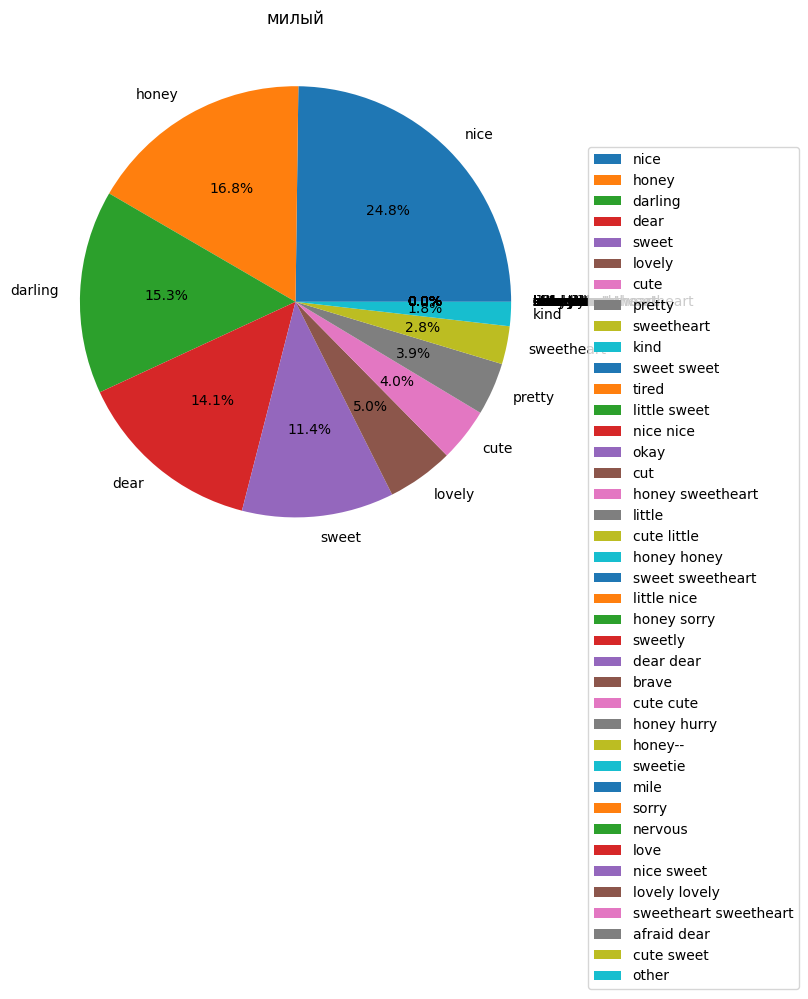

In [197]:
word = "милый"
orig, trans = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)
new_orig, new_trans = distil_dicts(orig, trans)
same_set, different_set = compare_dicts(new_orig, new_trans)
plot_variety_pie(new_orig, word)

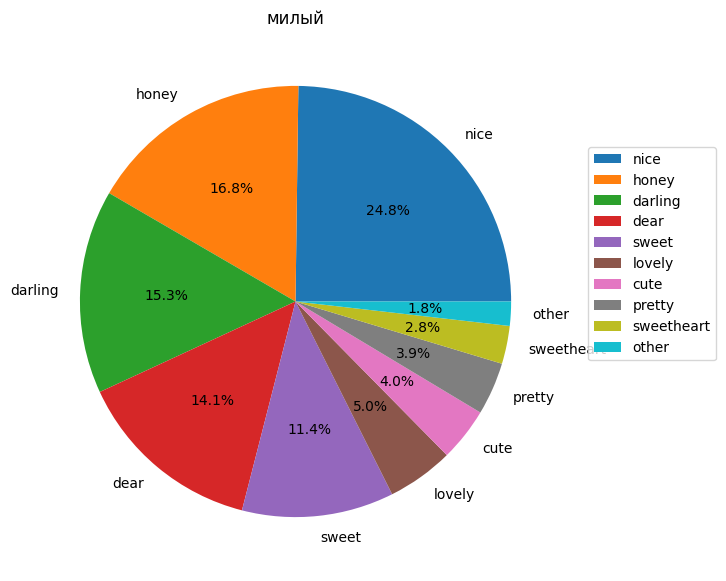

In [200]:
plot_variety_pie(grahp_orig, word)

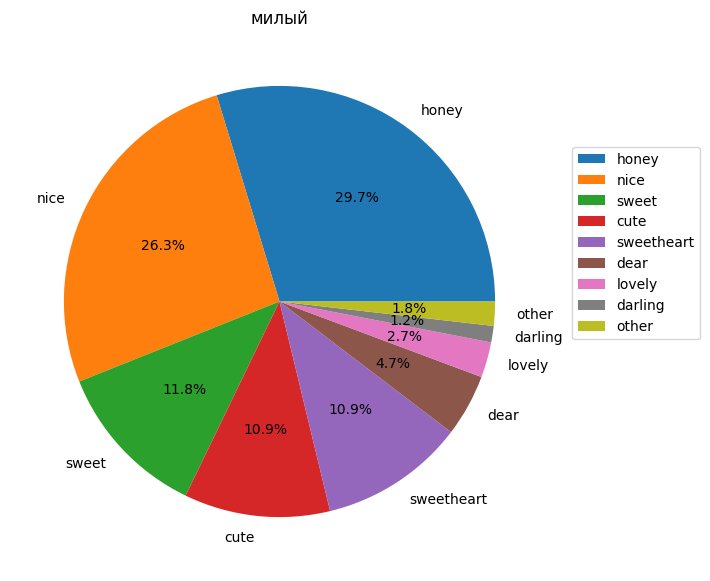

In [202]:
plot_variety_pie(grahp_trans, word)

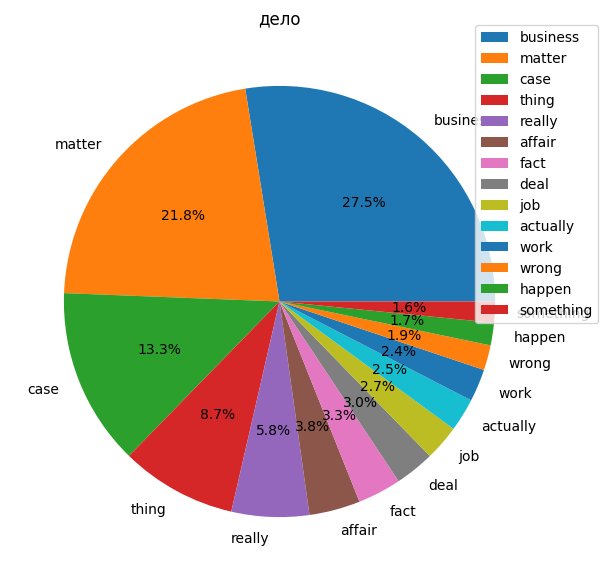

In [92]:
plot_variety_pie(another_grahp_trans, word)

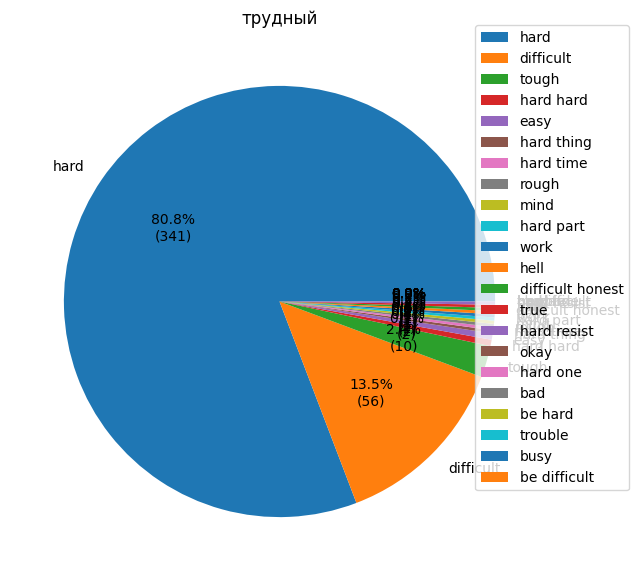

In [79]:
plot_variety_pie(new_trans, word)

## Анализ совпадений

In [ ]:
with open("subtitles_raw/en_raw_0-900.txt", "rt", encoding="utf-8") as f:
    en_corpus_raw = [line.strip() for line in f]

with open("subtitles_raw/ru_raw_0-900.txt", "rt", encoding="utf-8") as f:
    ru_corpus_raw = [line.strip() for line in f]

with open("corpora/subtitles/translations/opus10_whole.txt", "rt", encoding="utf-8") as f:
    translated_corpus_raw = [line.strip() for line in f]

In [ ]:
def compare_dicts(variety_dict: defaultdict, translated_dict: defaultdict):
    same_set = set()
    different_set = set()
    for key, value in variety_dict.items():
        same_set = same_set.union(translated_dict[key].intersection(value))
        different_set = different_set.union(translated_dict[key].symmetric_difference(value))
    for key, value in translated_dict.items():
        same_set = same_set.union(variety_dict[key].intersection(value))
        different_set = different_set.union(variety_dict[key].symmetric_difference(value))

    print(f"same {(len(same_set)/(len(same_set) + len(different_set)))*100}%")
    return same_set, different_set

In [ ]:
def pprint_set(typeset: set):
    with open("./tmpfile.txt", "wt", encoding="utf-8") as file:
        for i in typeset:
            file.write(f"SENTENCE NUMBER: {i}\n\n")
            file.write(f"RU: {ru_corpus_raw[i]}\n\n")
            file.write(f"EN: {en_corpus_raw[i]}\n\n")
            file.write(f"TRANSLATED DOC: {en_translated_docs[i]}\n\n")
            file.write(f"TRANSLATED: {translated_corpus_raw[i]}\n\n")
            file.write("=========================\n\n")

In [ ]:
def compare_dicts_one_word(variety_dict: defaultdict, translated_dict: defaultdict, word: str):
    same_set = set()
    different_set = set()
    for key, value in variety_dict.items():
        if key == word:
            same_set = same_set.union(translated_dict[key].intersection(value))
            different_set = different_set.union(translated_dict[key].symmetric_difference(value))
    for key, value in translated_dict.items():
        if key == word:
            same_set = same_set.union(variety_dict[key].intersection(value))
            different_set = different_set.union(variety_dict[key].symmetric_difference(value))

    print(f"same {(len(same_set)/(len(same_set) + len(different_set)))*100}%")
    return same_set, different_set

In [ ]:
exact_translation = "expensive"
s_set, d_set = compare_dicts_one_word(new_orig, new_trans, exact_translation)

Trying to calculate metrics

In [ ]:
with open("subtitles_raw/en_raw_0-900.txt", "rt", encoding="utf-8") as f:
    en_corpus_raw = [line.strip() for line in f]

with open("subtitles_raw/ru_raw_0-900.txt", "rt", encoding="utf-8") as f:
    ru_corpus_raw = [line.strip() for line in f]

with open("corpora/subtitles/translations/opus10_whole.txt", "rt", encoding="utf-8") as f:
    translated_corpus_raw = [line.strip() for line in f]

In [ ]:
import nltk
from nltk.translate import meteor_score

predictions = ['a', 'a', 'a', 'b']
references = [['b', 'a', 'a', 'a']]
meteor_score.meteor_score(references, predictions)

In [ ]:
x =  [val for val in trans.values()]
all_machine_sentences_for_word = []
for w in x:
    for el in w:
        all_machine_sentences_for_word.append(el)

In [ ]:
meteor_scores = []
for sentence_number in all_machine_sentences_for_word:
    predictions = [str(token) for token in en_translated_docs[sentence_number]]
    references = [[str(token) for token in en_docs[sentence_number]]]
    meteor_scores.append(meteor_score.meteor_score(references, predictions))

# Метрики

In [ ]:
from evaluate import load
bertscore = load("bertscore")

In [ ]:
with open("corpora/subtitles/translations/opus10_meteor.txt", "rt", encoding='utf-8') as f:
    meteor_data = [float(line.rstrip()) for line in f.readlines()]

In [ ]:
meteor_trans = []
for key, value in trans.items():
    for idx in value:
        meteor_trans.append(meteor_data[idx])

In [ ]:
get_meteor(new_trans)

In [ ]:
word = "работа"
orig, trans, hell = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)

In [ ]:
def distil_dicts(orig, trans):
    sum_all = sum(map(lambda x: len(x), orig.values()))
    blacklist = []
    new_orig = defaultdict(list)
    for key, value in orig.items():
        if len(value) < sum_all / 100:
            blacklist += value
        else:
            new_orig[key] = value

    new_trans = defaultdict(list)
    for key, value in trans.items():
        new = []
        for el in value:
            if el not in blacklist:
                new.append(el)
        new_trans[key] = new
    
    return new_orig, new_trans

In [ ]:
new_orig, new_trans = distil_dicts(orig, trans)

In [ ]:
plot_variety_pie(new_orig, "работа")

In [ ]:
def get_meteor(trans):
    meteor_trans = []
    for key, value in trans.items():
        for idx in value:
            meteor_trans.append(meteor_data[idx])
    return sum(meteor_trans) / len(meteor_trans)

In [ ]:
def get_bertscore(trans):
    refs = []
    preds = []
    for val in trans.values():
        for i in val:
            refs.append(en_corpus_raw[i])
            preds.append(translated_corpus_raw[i])
    results = bertscore.compute(predictions=preds, references=refs, lang="en")
    return results

In [ ]:
def metrix_conveyor(wordlist):
    bscores = []
    meteorscores = []
    for word in wordlist:
        orig, trans, hell = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)
        new_orig, new_trans = distil_dicts(orig, trans)
        meteorscores.append(get_meteor(new_trans))
        bscores.append(get_bertscore(new_trans))
    return bscores, meteorscores

In [ ]:
wordlist = ['друг', 'женщина', 'любить', 'найти', 'новый', 'старый', 'работа', 'ребенок', 'бояться', 'дело', 'милый', 'отличный']

In [ ]:
bscores, meteorscores = metrix_conveyor(wordlist)

In [ ]:
for i, score in enumerate(bscores):
    precisions = [prec for prec in score['precision']]
    print(f"{wordlist[i]}: meteor {meteorscores[i]} | bertscore {sum(precisions) / len(precisions)}")

In [ ]:
word = "любить"
orig, trans, hell = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)

In [ ]:
bscore = get_bertscore(new_trans)
precisions = [prec for prec in bscore['precision']]
sum(precisions) / len(precisions)

In [ ]:
x = get_meteor(new_trans)
x

In [ ]:
word = "отличный"
orig, trans, hell = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)

In [ ]:
new_orig, new_trans = distil_dicts(orig, trans)

In [ ]:
indexes = []
for key, value in new_orig.items():
    indexes += value

In [ ]:
ru_all_docs = ru_docs
en_all_docs = en_docs

## Контекстуализированные модели (часть анализа)

In [ ]:
def fill_bert_dict_for_one_word(indexes: list, original_word: str, aligned_text: list):
    MASK_TOKEN = '[MASK]'
    bert_word_dict = defaultdict(list)
    for line_idx in tqdm(indexes):
        ru_doc = ru_all_docs[line_idx]
        ru_token_idx = -1;
        for j, token in enumerate(ru_doc):
            if token.lemma_.lower() == original_word:
                if ru_token_idx != -1: 
                    ru_token_idx = -1
                    break
                else:
                    ru_token_idx = j
        if ru_token_idx != -1:
            en_token_idx = -1
            en_tokens = [token.text for token in en_all_docs[line_idx]]
            for src, tgt in aligned_text[line_idx]:
                if src == ru_token_idx:
                    if en_token_idx != -1:
                        en_token_idx = -1
                        break
                    else:
                        en_token_idx = tgt
            if en_token_idx != -1:
                en_tokens[en_token_idx] = MASK_TOKEN
                pred = model(' '.join(en_tokens))
                bert_word_dict[str(line_idx)] = pred
    return bert_word_dict

In [ ]:
from transformers import pipeline
model = pipeline('fill-mask', model='bert-base-uncased')

In [ ]:
pred = model("From tomorrow it 's a new life for us , no more [MASK] and we 'll get a butler , too .")
pred

In [ ]:
bert_word_dict = fill_bert_dict_for_one_word(indexes, "работа", aligned_inter)
bert_word_dict

In [ ]:
variety_dict = defaultdict(list)
for key, value in bert_word_dict.items():
    variety_dict[value[0]["token_str"].lower()].append(key)

In [ ]:
plot_variety_pie(variety_dict, "работа")